In [1]:
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import copy

from src import tsUtils
from src.synthcontrol.syntheticControl import RobustSyntheticControl
from src.synthcontrol.multisyntheticControl import MultiRobustSyntheticControl


In [2]:
def simpleFunctionOne(theta,rho,T):
    p = theta+(rho*theta)/T*np.exp(rho/T)+np.cos(2*(rho%360)*np.pi/180)+np.sin((rho%360)*np.pi/180)+np.cos(2*(rho%180)*np.pi/180)+np.sin((rho%180)*np.pi/180)

    return p

def simpleFunctionTwo(theta,rho,T):
    
    alpha=0.7
    
    exp_term = np.exp(-theta - rho/T -  (alpha * theta * rho/T))

    p =  10.0*(1/1+exp_term)

    return p

def generateDataMatrix(N, T, genFunction, rowParams, colParams):

    matrix = np.zeros([N, T])
    for i in range(0, N):
        for j in range(0, T):
            matrix[i, j] = genFunction(rowParams[i], colParams[j],T)

    return matrix

'''
def generateFirstRow(matrix, weights):

    (N, T) = np.shape(matrix)
    assert(len(weights) == N)
    weights = weights.reshape([N, 1])

    weights = weights/np.sum(weights)

    return np.dot(weights.T, matrix)
'''

def generateOneMetricMatrix(N, T, TrainingEnd, genFunction, rowParams, colParams, noise):

    meanMatrix = generateDataMatrix(N, T, genFunction, rowParams, colParams)
    noiseMatrix = np.random.normal(0.0, noise, [N, T])
    observationMatrix = meanMatrix + noiseMatrix
    return observationMatrix, meanMatrix


In [3]:
def save_synthetic_data(N, T, TrainingEnd, output_dir,noise):
    # generate metric matrices
    genFunctionOne = simpleFunctionOne
    genFunctionTwo = simpleFunctionTwo


    thetaArrayParams = np.random.uniform(0.0, 1.0, N)

    rowParams = thetaArrayParams
    colParams = np.arange(T)


    # metric 1
    observationMatrix1, meanMatrix1= generateOneMetricMatrix(N, T, TrainingEnd, genFunctionOne,  rowParams, colParams, noise)

    # metric 2
    observationMatrix2, meanMatrix2 = generateOneMetricMatrix(N, T, TrainingEnd, genFunctionTwo, rowParams, colParams, noise)
    
    combined_observation = np.zeros((N,T,2))
    mask = np.zeros((N,T,2))
    combined_observation[:,:,0] = observationMatrix1
    combined_observation[:,:,1] = observationMatrix2
    np.save(output_dir+'data.npy',combined_observation)
    np.save(output_dir+'mask.npy',mask)
    np.save(output_dir+'obs1.npy',observationMatrix1)
    np.save(output_dir+'obs2.npy',observationMatrix2)
    np.save(output_dir+'mean1.npy',meanMatrix1)
    np.save(output_dir+'mean2.npy',meanMatrix2)
    

In [ ]:
import os
N = 11
T=2000
i=1
noise_array = [0.5,1,2]
op_dir = '../../../deep_synthetic_ctrl/datasets/synthetic_data'
for noise in noise_array:
    print(N)
    TrainingEnd = 1600
    outfile = op_dir + f'_noise_{noise}/'
    if not(os.path.exists(outfile)):
        os.mkdir(outfile)
    save_synthetic_data(N, T, TrainingEnd, outfile,noise)
    i=i+1



In [2]:
#Run analysis
import numpy as np
output_dir= '../../../deep_synthetic_ctrl/datasets/synthetic_data_noise_1/'

obs1 = np.load(output_dir+'obs1.npy')
obs2 = np.load(output_dir+'obs2.npy')
mean1 = np.load(output_dir+'mean1.npy')
mean2 = np.load(output_dir+'mean2.npy')
print(mean1.shape)

(11, 2000)


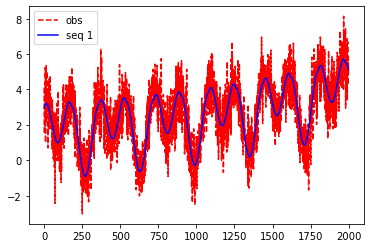

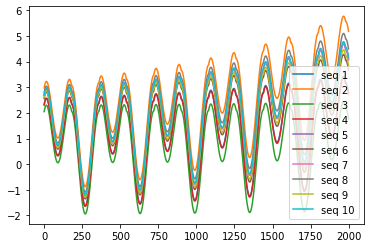

In [9]:
from matplotlib import pyplot as plt
time = np.arange(2000)
plt.figure()
plt.plot(time,obs1[0],'r--',label='obs')
plt.plot(time,mean1[0],'b',label='seq 0')
plt.legend()
plt.figure()
for i in range(1,11):
    plt.plot(time,mean1[i],label=f'seq {i}')
plt.legend()

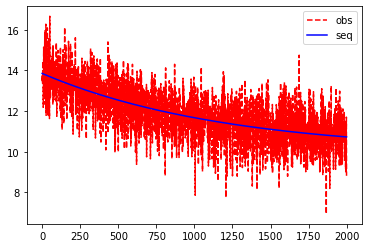

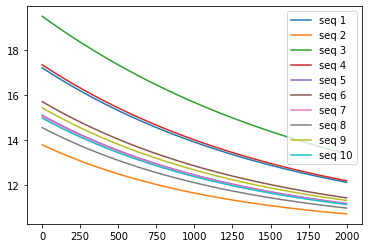

In [11]:
from matplotlib import pyplot as plt
time = np.arange(2000)
plt.figure()
plt.plot(time,obs2[0],'r--',label='obs')
plt.plot(time,mean2[0],'b',label='seq')
plt.legend()
plt.figure()
for i in range(1,11):
    plt.plot(time,mean2[i],label=f'seq {i}')
plt.legend()

In [17]:
#MSE
op_dir = '../../../deep_synthetic_ctrl/datasets/synthetic_data'
noise_array = [0.5,1,2]
for x in range(3):
    
    output_dir = op_dir +f'_noise_{noise_array[x]}/'
    observationMatrix1 = np.load(output_dir+'obs1.npy')
    observationMatrix2 = np.load(output_dir+'obs2.npy')
    meanMatrix1 = np.load(output_dir+'mean1.npy')
    meanMatrix2 = np.load(output_dir+'mean2.npy')
    N = observationMatrix1.shape[0] -1
    T = observationMatrix1.shape[1]
    TrainingEnd = 1600
    trainingDict1 = {}
    testDict1 = {}
    trainingDict2 = {}
    testDict2 = {}
    meanTrainingDict1 = {}
    meanTestDict1 = {}
    meanTrainingDict2 = {}
    meanTestDict2 = {}
    
    for i in range(0, N+1):

        trainingDict1.update({str(i): observationMatrix1[i, 0:TrainingEnd]})
        meanTrainingDict1.update({str(i): meanMatrix1[i, 0:TrainingEnd]})

        testDict1.update({str(i): observationMatrix1[i, TrainingEnd:]})
        meanTestDict1.update({str(i): meanMatrix1[i, TrainingEnd:]})
    for i in range(0, N+1):

        trainingDict2.update({str(i): observationMatrix2[i, 0:TrainingEnd]})
        meanTrainingDict2.update({str(i): meanMatrix2[i, 0:TrainingEnd]})

        testDict2.update({str(i): observationMatrix2[i, TrainingEnd:]})
        meanTestDict2.update({str(i): meanMatrix2[i, TrainingEnd:]})
    keySeriesLabel = '0'
    otherSeriesLabels = []
    for ind in range(1, N+1):
        otherSeriesLabels.append(str(ind))

    # RSC analysis
    singvals = 8
    trainDF1 = pd.DataFrame(data=trainingDict1)
    testDF1 = pd.DataFrame(data=testDict1)
    meanTrainDF1 = pd.DataFrame(data=meanTrainingDict1)
    meanTestDF1 = pd.DataFrame(data=meanTestDict1)
    
    trainDF2 = pd.DataFrame(data=trainingDict2)
    testDF2 = pd.DataFrame(data=testDict2)
    meanTrainDF2 = pd.DataFrame(data=meanTrainingDict2)
    meanTestDF2 = pd.DataFrame(data=meanTestDict2)
    
    rscmodel1 = RobustSyntheticControl(keySeriesLabel, singvals, len(trainDF1), probObservation=1.0, svdMethod='numpy', otherSeriesKeysArray=otherSeriesLabels)
    
    rscmodel1.fit(trainDF1)
    predictionsRSC1 = rscmodel1.predict(testDF1)
    
    rscRMSE1 = np.sqrt(np.mean((predictionsRSC1 - meanTestDict1[keySeriesLabel])**2))
    #print("\n\n *** RSC rmse1:")
    #print(rscRMSE1)

    ############################
    ##### RSC for metric 2
    rscmodel2 = RobustSyntheticControl(keySeriesLabel, singvals, len(trainDF2), probObservation=1.0, svdMethod='numpy', otherSeriesKeysArray=otherSeriesLabels)

    # fit the model
    rscmodel2.fit(trainDF2)
    predictionsRSC2 = rscmodel2.predict(testDF2)

    
    rscRMSE2 = np.sqrt(np.mean((predictionsRSC2 - meanTestDict2[keySeriesLabel])**2))
    #print("\n\n *** RSC rmse2:")
    #print(rscRMSE2)

    ############################
    ####  multi RSC model (combined) --
    relative_weights = [1.0, 1]

    # instantiate the model
    mrscmodel = MultiRobustSyntheticControl(2, relative_weights, keySeriesLabel, singvals, len(trainDF1), probObservation=1.0, svdMethod='numpy', otherSeriesKeysArray=otherSeriesLabels)
    
    # fit
    mrscmodel.fit([trainDF1, trainDF2])
    
    # predict
    combinedPredictionsArray = mrscmodel.predict([testDF1[otherSeriesLabels], testDF2[otherSeriesLabels]])

    # split the predictions for the metrics
    predictionsmRSC_1 = combinedPredictionsArray[0]
    predictionsmRSC_2 = combinedPredictionsArray[1]

    # compute RMSE
    mrscRMSE1 = np.sqrt(np.mean((predictionsmRSC_1 - meanTestDict1[keySeriesLabel])**2))
    mrscRMSE2 = np.sqrt(np.mean((predictionsmRSC_2 - meanTestDict2[keySeriesLabel])**2))

    
    print(f'RSC MSE for noise = {noise_array[x]}:')
    print(f'RSC method: {rscRMSE1},{rscRMSE2}')
    print(f'mRSC method: {mrscRMSE1},{mrscRMSE2}')
    
    np.save(output_dir+'rsc_pred.npy',predictionsRSC1)
    np.save(output_dir+'mrsc_pred.npy', predictionsmRSC_1)
    


RSC MSE for noise = 0.5:
RSC method: 1.5784798739621844,0.9968757070108639
mRSC method: 1.3095016507937924,1.188031083666661
RSC MSE for noise = 1:
RSC method: 1.485907644288792,2.223612566594892
mRSC method: 1.1204435978399272,1.1421370848514403
RSC MSE for noise = 2:
RSC method: 6.383420413147062,1.935501873843837
mRSC method: 4.1781029818704125,4.118039253923423


In [4]:
import os
N_array = [6,16,21,26,31]
T=2000
i=1
op_dir = '../../../deep_synthetic_ctrl/datasets/synthetic_data'
for N in N_array:
    print(N)
    TrainingEnd = 1600
    outfile = op_dir + f'_N_{N}/'
    if not(os.path.exists(outfile)):
        os.mkdir(outfile)
    save_synthetic_data(N, T, TrainingEnd, outfile,1)
    i=i+1


6
16
21
26
31


(26, 2000)


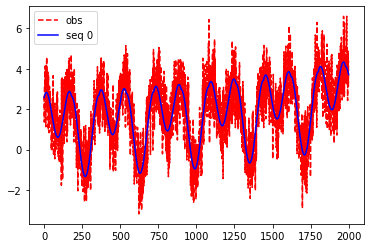

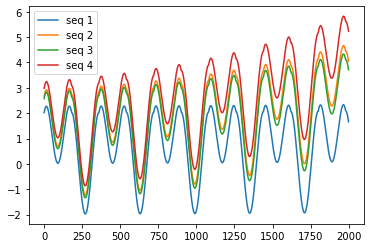

In [9]:
#Run analysis
import numpy as np
output_dir= '../../../deep_synthetic_ctrl/datasets/synthetic_data_N_26/'

obs1 = np.load(output_dir+'obs1.npy')
obs2 = np.load(output_dir+'obs2.npy')
mean1 = np.load(output_dir+'mean1.npy')
mean2 = np.load(output_dir+'mean2.npy')
print(mean1.shape)
from matplotlib import pyplot as plt
time = np.arange(2000)
plt.figure()
plt.plot(time,obs1[0],'r--',label='obs')
plt.plot(time,mean1[0],'b',label='seq 0')
plt.legend()
plt.figure()
for i in range(1,5):
    plt.plot(time,mean1[i],label=f'seq {i}')
plt.legend()

In [6]:
#MSE
N_array = [6,11,16,21,26]
op_dir = '../../../deep_synthetic_ctrl/datasets/synthetic_data'
for x in range(4):
    
    output_dir = op_dir +f'_N_{N_array[x]}/'
    observationMatrix1 = np.load(output_dir+'obs1.npy')
    observationMatrix2 = np.load(output_dir+'obs2.npy')
    meanMatrix1 = np.load(output_dir+'mean1.npy')
    meanMatrix2 = np.load(output_dir+'mean2.npy')
    N = observationMatrix1.shape[0] -1
    T = observationMatrix1.shape[1]
    TrainingEnd = 1600
    trainingDict1 = {}
    testDict1 = {}
    trainingDict2 = {}
    testDict2 = {}
    meanTrainingDict1 = {}
    meanTestDict1 = {}
    meanTrainingDict2 = {}
    meanTestDict2 = {}
    
    for i in range(0, N+1):

        trainingDict1.update({str(i): observationMatrix1[i, 0:TrainingEnd]})
        meanTrainingDict1.update({str(i): meanMatrix1[i, 0:TrainingEnd]})

        testDict1.update({str(i): observationMatrix1[i, TrainingEnd:]})
        meanTestDict1.update({str(i): meanMatrix1[i, TrainingEnd:]})
    for i in range(0, N+1):

        trainingDict2.update({str(i): observationMatrix2[i, 0:TrainingEnd]})
        meanTrainingDict2.update({str(i): meanMatrix2[i, 0:TrainingEnd]})

        testDict2.update({str(i): observationMatrix2[i, TrainingEnd:]})
        meanTestDict2.update({str(i): meanMatrix2[i, TrainingEnd:]})
    keySeriesLabel = '0'
    otherSeriesLabels = []
    for ind in range(1, N+1):
        otherSeriesLabels.append(str(ind))

    # RSC analysis
    singvals = 8
    trainDF1 = pd.DataFrame(data=trainingDict1)
    testDF1 = pd.DataFrame(data=testDict1)
    meanTrainDF1 = pd.DataFrame(data=meanTrainingDict1)
    meanTestDF1 = pd.DataFrame(data=meanTestDict1)
    
    trainDF2 = pd.DataFrame(data=trainingDict2)
    testDF2 = pd.DataFrame(data=testDict2)
    meanTrainDF2 = pd.DataFrame(data=meanTrainingDict2)
    meanTestDF2 = pd.DataFrame(data=meanTestDict2)
    
    rscmodel1 = RobustSyntheticControl(keySeriesLabel, singvals, len(trainDF1), probObservation=1.0, svdMethod='numpy', otherSeriesKeysArray=otherSeriesLabels)
    
    rscmodel1.fit(trainDF1)
    predictionsRSC1 = rscmodel1.predict(testDF1)
    
    rscRMSE1 = np.sqrt(np.mean((predictionsRSC1 - meanTestDict1[keySeriesLabel])**2))
    #print("\n\n *** RSC rmse1:")
    #print(rscRMSE1)

    ############################
    ##### RSC for metric 2
    rscmodel2 = RobustSyntheticControl(keySeriesLabel, singvals, len(trainDF2), probObservation=1.0, svdMethod='numpy', otherSeriesKeysArray=otherSeriesLabels)

    # fit the model
    rscmodel2.fit(trainDF2)
    predictionsRSC2 = rscmodel2.predict(testDF2)

    
    rscRMSE2 = np.sqrt(np.mean((predictionsRSC2 - meanTestDict2[keySeriesLabel])**2))
    #print("\n\n *** RSC rmse2:")
    #print(rscRMSE2)

    ############################
    ####  multi RSC model (combined) --
    relative_weights = [1.0, 1]

    # instantiate the model
    mrscmodel = MultiRobustSyntheticControl(2, relative_weights, keySeriesLabel, singvals, len(trainDF1), probObservation=1.0, svdMethod='numpy', otherSeriesKeysArray=otherSeriesLabels)
    
    # fit
    mrscmodel.fit([trainDF1, trainDF2])
    
    # predict
    combinedPredictionsArray = mrscmodel.predict([testDF1[otherSeriesLabels], testDF2[otherSeriesLabels]])

    # split the predictions for the metrics
    predictionsmRSC_1 = combinedPredictionsArray[0]
    predictionsmRSC_2 = combinedPredictionsArray[1]

    # compute RMSE
    mrscRMSE1 = np.sqrt(np.mean((predictionsmRSC_1 - meanTestDict1[keySeriesLabel])**2))
    mrscRMSE2 = np.sqrt(np.mean((predictionsmRSC_2 - meanTestDict2[keySeriesLabel])**2))

    np.save(output_dir+'rsc_pred.npy',predictionsRSC1)
    np.save(output_dir+'mrsc_pred.npy', predictionsmRSC_1)
    print(f'RSC MSE for N = {N}:')
    print(f'RSC method: {rscRMSE1},{rscRMSE2}')
    print(f'mRSC method: {mrscRMSE1},{mrscRMSE2}')


RSC MSE for N = 5:
RSC method: 0.4501116027040459,0.4701490789184164
mRSC method: 0.537384080270436,0.463278205002492
RSC MSE for N = 15:
RSC method: 1.3222781289949304,0.9213708945315581
mRSC method: 1.3305899406712938,1.2307032674314962
RSC MSE for N = 20:
RSC method: 0.7865853750607508,0.8740023872384892
mRSC method: 0.8136083848222222,0.7892028991603707
RSC MSE for N = 25:
RSC method: 0.6032313454306116,0.8896150240220968
mRSC method: 0.6313689423475712,0.6581916025693394


In [5]:
#MSE
p_array = [0.1,0.2,0.3,0.5]
op_dir = '../../../deep_synthetic_ctrl/datasets/synthetic_data'
for x in range(4):
    
    output_dir = op_dir +f'_missing_{p_array[x]}/'
    mask = np.load(output_dir+'mask.npy')
    data = np.load(output_dir+'data.npy')
    data[np.nonzero(mask)] = 0
    observationMatrix1 = data[:,:,0]
    observationMatrix2 = data[:,:,1]
    meanMatrix1 = np.load(output_dir+'mean1.npy')
    meanMatrix2 = np.load(output_dir+'mean2.npy')
    N = observationMatrix1.shape[0] -1
    T = observationMatrix1.shape[1]
    TrainingEnd = 1600
    trainingDict1 = {}
    testDict1 = {}
    trainingDict2 = {}
    testDict2 = {}
    meanTrainingDict1 = {}
    meanTestDict1 = {}
    meanTrainingDict2 = {}
    meanTestDict2 = {}
    
    for i in range(0, N+1):

        trainingDict1.update({str(i): observationMatrix1[i, 0:TrainingEnd]})
        meanTrainingDict1.update({str(i): meanMatrix1[i, 0:TrainingEnd]})

        testDict1.update({str(i): observationMatrix1[i, TrainingEnd:]})
        meanTestDict1.update({str(i): meanMatrix1[i, TrainingEnd:]})
    for i in range(0, N+1):

        trainingDict2.update({str(i): observationMatrix2[i, 0:TrainingEnd]})
        meanTrainingDict2.update({str(i): meanMatrix2[i, 0:TrainingEnd]})

        testDict2.update({str(i): observationMatrix2[i, TrainingEnd:]})
        meanTestDict2.update({str(i): meanMatrix2[i, TrainingEnd:]})
    keySeriesLabel = '0'
    otherSeriesLabels = []
    for ind in range(1, N+1):
        otherSeriesLabels.append(str(ind))

    # RSC analysis
    singvals = 1
    trainDF1 = pd.DataFrame(data=trainingDict1)
    testDF1 = pd.DataFrame(data=testDict1)
    meanTrainDF1 = pd.DataFrame(data=meanTrainingDict1)
    meanTestDF1 = pd.DataFrame(data=meanTestDict1)
    
    trainDF2 = pd.DataFrame(data=trainingDict2)
    testDF2 = pd.DataFrame(data=testDict2)
    meanTrainDF2 = pd.DataFrame(data=meanTrainingDict2)
    meanTestDF2 = pd.DataFrame(data=meanTestDict2)
    
    rscmodel1 = RobustSyntheticControl(keySeriesLabel, singvals, len(trainDF1), probObservation=1-p_array[x], svdMethod='numpy', otherSeriesKeysArray=otherSeriesLabels)
    
    rscmodel1.fit(trainDF1)
    predictionsRSC1 = rscmodel1.predict(testDF1)
    
    rscRMSE1 = np.sqrt(np.mean((predictionsRSC1 - meanTestDict1[keySeriesLabel])**2))
    #print("\n\n *** RSC rmse1:")
    #print(rscRMSE1)

    ############################
    ##### RSC for metric 2
    rscmodel2 = RobustSyntheticControl(keySeriesLabel, singvals, len(trainDF2), probObservation=1-p_array[x], svdMethod='numpy', otherSeriesKeysArray=otherSeriesLabels)

    # fit the model
    rscmodel2.fit(trainDF2)
    predictionsRSC2 = rscmodel2.predict(testDF2)

    
    rscRMSE2 = np.sqrt(np.mean((predictionsRSC2 - meanTestDict2[keySeriesLabel])**2))
    #print("\n\n *** RSC rmse2:")
    #print(rscRMSE2)

    ############################
    ####  multi RSC model (combined) --
    relative_weights = [1.0, 1]

    # instantiate the model
    mrscmodel = MultiRobustSyntheticControl(2, relative_weights, keySeriesLabel, singvals, len(trainDF1), probObservation=1-p_array[x], svdMethod='numpy', otherSeriesKeysArray=otherSeriesLabels)
    
    # fit
    mrscmodel.fit([trainDF1, trainDF2])
    
    # predict
    combinedPredictionsArray = mrscmodel.predict([testDF1[otherSeriesLabels], testDF2[otherSeriesLabels]])

    # split the predictions for the metrics
    predictionsmRSC_1 = combinedPredictionsArray[0]
    predictionsmRSC_2 = combinedPredictionsArray[1]

    # compute RMSE
    mrscRMSE1 = np.sqrt(np.mean((predictionsmRSC_1 - meanTestDict1[keySeriesLabel])**2))
    mrscRMSE2 = np.sqrt(np.mean((predictionsmRSC_2 - meanTestDict2[keySeriesLabel])**2))
    np.save(output_dir+'rsc_pred.npy',predictionsRSC1)
    np.save(output_dir+'mrsc_pred.npy', predictionsmRSC_1)
    print(f'RSC MSE for data = {1-p_array[x]}:')
    print(f'RSC method: {rscRMSE1},{rscRMSE2}')
    print(f'mRSC method: {mrscRMSE1},{mrscRMSE2}')


RSC MSE for data = 0.9:
RSC method: 1.4404104653778431,3.2956062283748886
mRSC method: 2.2604483232608943,3.2174809438777467
RSC MSE for data = 0.8:
RSC method: 2.1460828563227596,5.501005294543636
mRSC method: 2.7642255763239816,5.442159435527124
RSC MSE for data = 0.7:
RSC method: 2.7923548992217517,7.223291285350145
mRSC method: 3.1710344709729297,7.186516773858722
RSC MSE for data = 0.5:
RSC method: 3.6242248217555635,9.48467999017542
mRSC method: 3.7364290028779843,9.473539150798375
